<a href="https://colab.research.google.com/github/ander-yamamoto/dio-bairesdev/blob/main/face-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install facenet-pytorch MTCNN


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.

In [1]:
import os
import requests
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from io import BytesIO
from torchvision import transforms

!pip install simple-image-download tqdm

from simple_image_download import simple_image_download as simp

to_tensor = transforms.ToTensor()

def download_with_progress(group, query, num_images):
    downloader = simp.simple_image_download()
    links = downloader.urls(f'{query} {group}', num_images)  # pega URLs sem baixar ainda

    save_dir = os.path.join(group, query)
    os.makedirs(save_dir, exist_ok=True)

    for url in tqdm(links, desc=f"Baixando {query}"):
        try:
            # 1. Baixar o conteúdo
            response = requests.get(url, timeout=5)
            response.raise_for_status()

            # 2. Tentar abrir como imagem
            img = Image.open(BytesIO(response.content)).convert("RGB")

            # 3. Tentar converter em tensor (garante que é compatível com torchvision)
            _ = to_tensor(img)

            # 4. Se chegou até aqui, é válido → salvar
            file_name = os.path.join(save_dir, os.path.basename(url.split("?")[0]))
            img.save(file_name, format="JPEG")

        except (requests.RequestException, UnidentifiedImageError, OSError, ValueError) as e:
            # Ignora links ruins ou arquivos não imagem
            # print(f"[ERRO] Ignorado: {url} ({e})")
            continue

group = "Friends"
category=["Ross", "Chandler", "Joey", "Phoebe", "Monica", "Rachel"]


for cat in category:
  if not os.path.exists(os.path.join(group, cat)):
    download_with_progress(group, cat, 40)

  else:
    print(f"Banco de imagens de {cat} já existe. Pulando download.")

# Listar categorias existentes

categories = [
    os.path.join(group, c)
    for c in os.listdir(group)
    if os.path.isdir(os.path.join(group, c))
]
print("Categorias:", categories)

INFO: pip is looking at multiple versions of simple-image-download to determine which version is compatible with other requirements. This could take a while.


Baixando Rachel: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]

Categorias: ['Friends/Ross', 'Friends/Chandler', 'Friends/Joey', 'Friends/Rachel', 'Friends/Monica', 'Friends/Phoebe']


  0%|          | 0.00/107M [00:00<?, ?B/s]

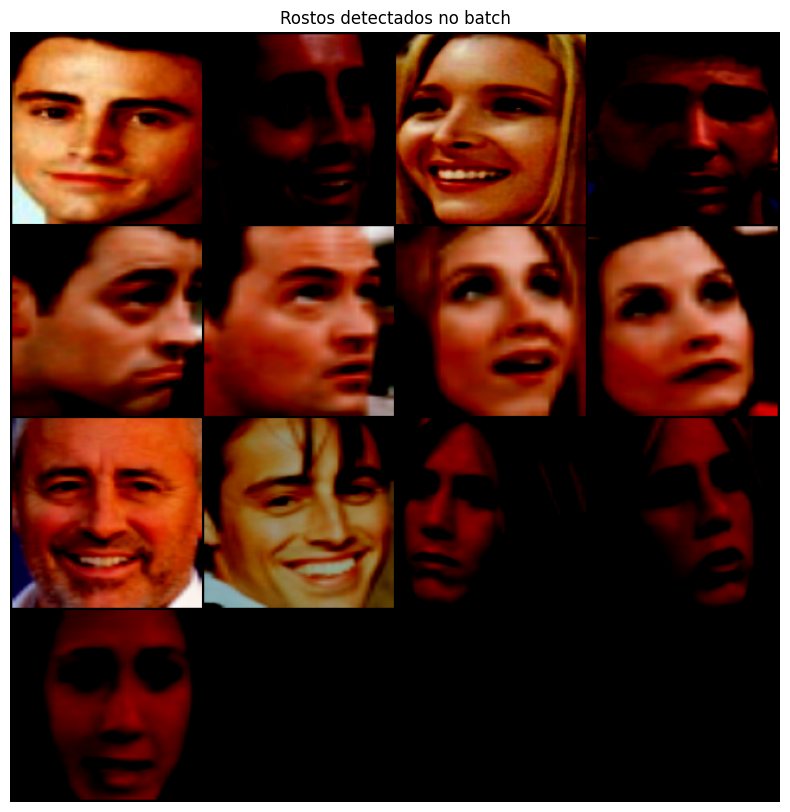

Total de rostos detectados: 13
Shape dos embeddings: torch.Size([1, 512])


In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN, InceptionResnetV1

# =====================================
# 1. Dataset & DataLoader
# =====================================
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # padroniza tamanho
    transforms.ToTensor()
])

dataset = ImageFolder(group, transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

class_names = dataset.classes

# =====================================
# 2. Modelos: detector (MTCNN) e FaceNet
# =====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mtcnn = MTCNN(keep_all=True, device=device)  # pode detectar +1 rosto
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# =====================================
# 3. Pegar um batch
# =====================================
images, labels = next(iter(loader))

# converter de tensor para PIL (MTCNN espera PIL ou np.array)
to_pil = transforms.ToPILImage()

all_faces = []
all_embeddings = []
all_labels = []

for img, label in zip(images, labels):
    pil_img = to_pil(img)

    # detectar rostos
    faces = mtcnn(pil_img)   # pode retornar vários rostos [N, 3, 160, 160]

    if faces is not None:
        if faces.dim() == 3:   # se veio apenas 1 rosto
            faces = faces.unsqueeze(0)

        for f in faces:
            all_faces.append(f)
            all_labels.append(label.item())

            # embedding
            emb = resnet(f.unsqueeze(0).to(device)).detach().cpu()
            all_embeddings.append(emb)

# =====================================
# 4. Mostrar mosaico com labels
# =====================================
if all_faces:
    faces_tensor = torch.stack(all_faces)  # [N, 3, 160, 160]
    grid = make_grid(faces_tensor, nrow=4, padding=2)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Rostos detectados no batch")
    plt.show()

print("Total de rostos detectados:", len(all_faces))
print("Shape dos embeddings:", all_embeddings[0].shape if all_embeddings else None)



In [3]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# =====================================
# 1. Extrair embeddings do dataset inteiro
# =====================================
X = []
y = []

to_pil = transforms.ToPILImage()

for img, label in dataset:  # percorre TODAS as imagens
    pil_img = to_pil(img)

    # detectar rosto
    face = mtcnn(pil_img)
    if face is None:
        continue

    if face.dim() == 3:  # caso só 1 rosto
        face = face.unsqueeze(0)

    # pode ter múltiplos, mas vamos assumir 1 por imagem
    face = face[0]

    # gerar embedding
    emb = resnet(face.unsqueeze(0).to(device)).detach().cpu().numpy().flatten()

    X.append(emb)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("Embeddings extraídos:", X.shape)  # (N, 512)

# =====================================
# 2. Dividir treino e teste
# =====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =====================================
# 3. Treinar classificador SVM
# =====================================
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# =====================================
# 4. Avaliar no teste
# =====================================
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred))


Embeddings extraídos: (175, 512)
              precision    recall  f1-score   support

    Chandler       1.00      0.80      0.89         5
        Joey       0.83      1.00      0.91         5
      Monica       0.86      1.00      0.92         6
      Phoebe       1.00      0.83      0.91         6
      Rachel       1.00      1.00      1.00         7
        Ross       1.00      1.00      1.00         6

    accuracy                           0.94        35
   macro avg       0.95      0.94      0.94        35
weighted avg       0.95      0.94      0.94        35

[[4 1 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 6 0 0 0]
 [0 0 1 5 0 0]
 [0 0 0 0 7 0]
 [0 0 0 0 0 6]]


In [4]:
from PIL import Image, ImageDraw
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from torchvision import transforms

def predict_and_draw(img_path, clf, mtcnn, resnet, class_names, threshold=0.55):

    # Verifica se é link ou caminho local
    if img_path.startswith("http://") or img_path.startswith("https://"):
        response = requests.get(img_path, timeout=10)
        pil_img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        pil_img = Image.open(img_path).convert("RGB")

    # detectar rostos e bounding boxes
    boxes, probs = mtcnn.detect(pil_img)

    if boxes is None:
        print("Nenhum rosto detectado.")
        return pil_img

    draw = ImageDraw.Draw(pil_img)

    for box, prob in zip(boxes, probs):
        if box is None:
            continue

        x1, y1, x2, y2 = [int(b) for b in box]
        face_crop = pil_img.crop((x1, y1, x2, y2)).resize((160, 160))

        # transformar em tensor e embedding
        face_tensor = transforms.ToTensor()(face_crop).unsqueeze(0).to(device)
        emb = resnet(face_tensor).detach().cpu().numpy().flatten()

        # classificar
        pred = clf.predict([emb])[0]
        prob_pred = clf.predict_proba([emb]).max()

        # só desenha se a certeza for >= threshold
        if prob_pred >= threshold:
            label = f"{class_names[pred]} ({prob_pred:.2f})"
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1, y1 - 10), label, fill="red")

    plt.figure(figsize=(8,8))
    plt.imshow(np.array(pil_img))
    plt.axis("off")
    plt.show()


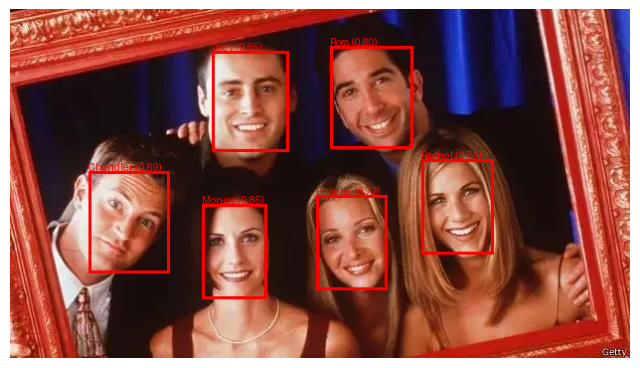

In [5]:
# exemplo de uso
result_img = predict_and_draw(
    "https://ichef.bbci.co.uk/ace/ws/624/cpsprodpb/646b/live/6573c010-79b9-11ef-b02d-c5f3b724a1ea.jpg.webp",
    clf, mtcnn, resnet, class_names)



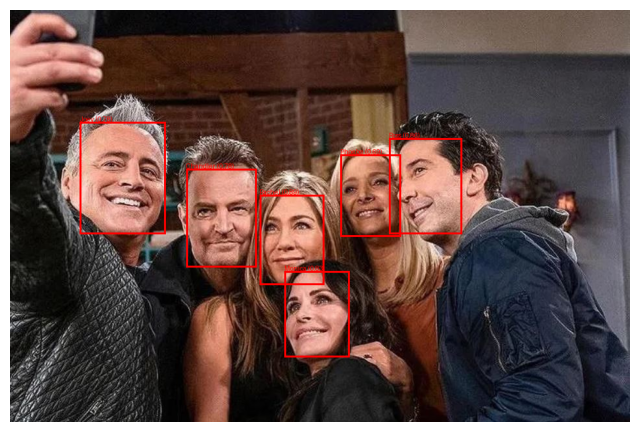

In [6]:
# exemplo de uso
result_img = predict_and_draw(
    "https://projetocolabora.com.br/wp-content/uploads/2024/05/friends2.jpg",
    clf, mtcnn, resnet, class_names)

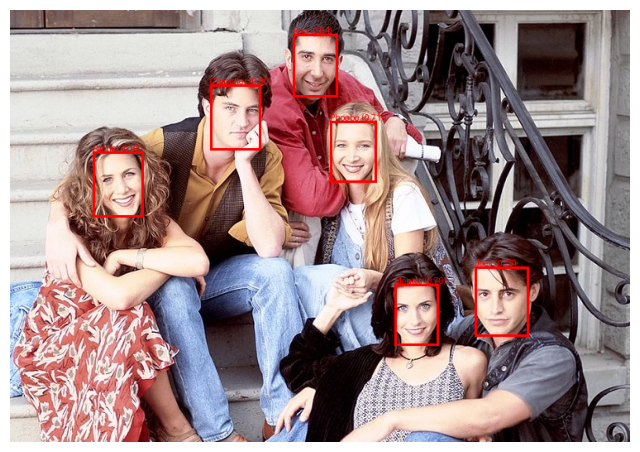

In [7]:
# exemplo de uso
result_img = predict_and_draw(
    "https://jpimg.com.br/uploads/2017/09/friends_repre.jpg",
    clf, mtcnn, resnet, class_names)


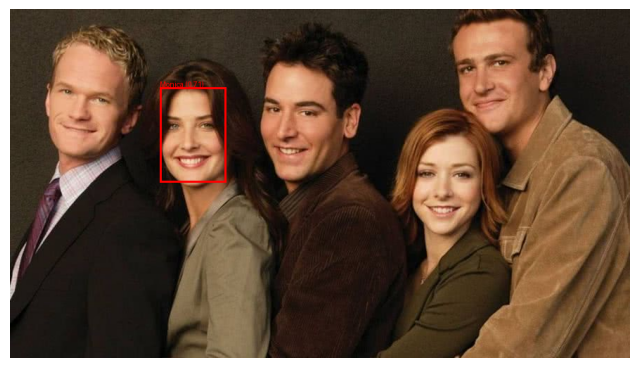

In [8]:
# exemplo de uso
result_img = predict_and_draw(
    "https://rollingstone.com.br/media/_versions/how_i_met_your_mother_foto_divulgacao__cbs_widelg.jpg",
    clf, mtcnn, resnet, class_names)

In [9]:
from ipywidgets import Widget
Widget.close_all()